### Basic RNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm
import random
%matplotlib inline

In [2]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set(''.join(words)))) #lol
token_lookup = {c: i+1 for i, c in enumerate(chars)}
token_lookup['.'] = 0
char_lookup = {i:c for c, i in token_lookup.items()}
TOTAL_TOKENS = len(char_lookup.keys())

In [4]:
# build the dataset

BLOCK_SIZE = 8 # context size to give the model in order to predict the next character

def build_dataset(corpus, block_size, codebook, padding_char="."):
    X, Y = [], []
    for word in corpus:
        start_padding = padding_char * block_size
        padded_word = f"{start_padding}{word}."
        tokenized_word = [codebook[c] for c in padded_word]
        for i in range(len(tokenized_word)-block_size):
            X.append(tokenized_word[i:i+block_size])
            Y.append(tokenized_word[i+block_size])
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    
    return X, Y


random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

x_train, y_train = build_dataset(words[:n1], BLOCK_SIZE, token_lookup)
x_valid, y_valid = build_dataset(words[n1:n2], BLOCK_SIZE, token_lookup)
x_test, y_test = build_dataset(words[n2:], BLOCK_SIZE, token_lookup)

torch.Size([182635, 8]) torch.Size([182635])
torch.Size([22803, 8]) torch.Size([22803])
torch.Size([22708, 8]) torch.Size([22708])


In [140]:
class RNN(nn.Module):
    
    def __init__(self, input_dims, hidden_dims, out_dims):
        
        super(RNN, self).__init__()
        
        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.out_dims = out_dims
        
        self.hidden_layer = nn.Linear(input_dims + hidden_dims, hidden_dims)
        self.out_layer = nn.Linear(input_dims + hidden_dims, out_dims)
        
    def forward(self, x, h):
        
        x_h = torch.cat((x, h), dim=1)
        next_hidden = torch.tanh(self.hidden_layer(x_h))
        next_out = torch.tanh(self.out_layer(x_h))
        
        return next_out, next_hidden
    
class Reshape(nn.Module):
    
    def __init__(self, target_shape):
        super(Reshape, self).__init__()
        self.target_shape = target_shape
        
    def forward(self, x):
        return x.view(self.target_shape)

class Model(nn.Module):
    
    def __init__(self, token_size:int, embedding_dims:int, hidden_dims:int, block_size:int):
        
        super(Model, self).__init__()
        
        self.hidden_dims = hidden_dims
        
        self.embedding_layer = nn.Embedding(token_size, embedding_dims)
        self.rnn_0 = RNN(embedding_dims, hidden_dims, hidden_dims)
        self.rnn_1 = RNN(embedding_dims, hidden_dims, hidden_dims)
        
        self.output = nn.Linear(hidden_dims, token_size)
        
    def forward(self, x):
        embedding = self.embedding_layer(x)
        hidden = torch.zeros(x.shape[0], self.hidden_dims)
        for emb_ix in range(embedding.shape[1]):
            next_token_embedding = embedding[:,emb_ix]
            out, hidden = self.rnn_0(next_token_embedding, hidden)
            out, hidden = self.rnn_1(next_token_embedding, hidden)
        
        out = self.output(out)
        
        return out

In [ ]:
EMBEDDING_DIMS = 24
HIDDEN_DIMS = 128

model = Model(embedding_dims=EMBEDDING_DIMS, token_size=TOTAL_TOKENS, hidden_dims=HIDDEN_DIMS, block_size=BLOCK_SIZE)
print(sum(p.numel() for p in model.parameters()))

device = 'cuda:1'
steps = 25000
print_steps = 2000
BATCH_SIZE = 256

losses = []

optim = torch.optim.Adam(model.parameters())
pbar = tqdm(range(steps))

for t in pbar:
    batch_ix = torch.randint(0, x_train.shape[0], (BATCH_SIZE,))
    batch = x_train[batch_ix]
    logits = model(batch)
    
    loss = F.cross_entropy(logits, y_train[batch_ix])
    losses.append(loss.item())
    pbar.set_description(desc=f'average loss: {(sum(losses[-100:])/100):.2f}')

    model.zero_grad()
    loss.backward()
    optim.step()

82467


average loss: 2.11:   8%|█▍                | 2057/25000 [00:22<04:29, 85.18it/s]

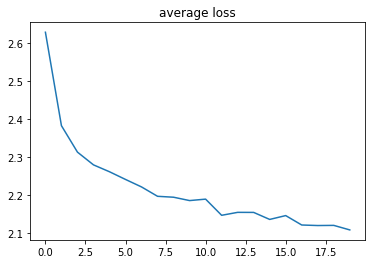

In [123]:
plt.plot(torch.tensor(losses).view(-1, 100).mean(1))
plt.title("average loss");

In [124]:
model.train(False)

# clculate training and validation loss
@torch.no_grad()
def calc_loss(x_target, y_target):
    logits = model(x_target)
    loss = F.cross_entropy(logits, y_target)
    return loss

('train', calc_loss(x_train, y_train).item()), ('val', calc_loss(x_valid, y_valid).item())

(('train', 2.1091744899749756), ('val', 2.130784511566162))

In [125]:
# sample
@torch.no_grad()
def sample():
    tokens = [0] * BLOCK_SIZE
    while True:
        cur_tokens = torch.tensor(tokens[-BLOCK_SIZE:]).unsqueeze(0)
        logits = model(cur_tokens)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        tokens.append(ix)
        if ix == 0:
            break
    return "".join([char_lookup[t] for t in tokens][BLOCK_SIZE:-1])

for i in range(20):
    print(sample())

triggotus
chaey
sunyah
rogran
pyasha
ricel
laigella
amrion
armilsa
jasqure
charri
emilipah
jajale
trintiel
meri
elyanna
zachyani
catel
danalynn
treisen


In [173]:
# think of convoluation as a kernel based "for loop"
# allows us to forward liner layers effeciently over space